In [1]:
from __future__ import annotations

#general naming conventions.
#in "optional" cells, the variable names start with "_". These are generally do visually peek at some data...

#use full words where possible, width instead of w. (x and y are exceptions)
#use snake case, caps for global, lowercase for local.
# follow swift-like wording (descriptive, full eglish words) -- but not camel cased...

# from google.colab import drive
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Tuple, List, Optional, Dict, Literal
from collections import defaultdict
from enum import Enum
import random, math, json, time, os
from PIL import Image, ImageDraw, ImageFont, ImageFile, ImageEnhance
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.functional as TVF
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

PathLike = Path | str
RGB = tuple[int, int, int]

BALANCE_TARGET_COUNT_PER_CLASS = 2000
SPLIT_PERCENT_TEST = 0.2
SPLIT_PERCENT_VALIDATION = 0.2

MAGIC_LEARNING_RATE = 0.000028
MAGIC_WEIGHT_DECAY = 0.0025
MAGIC_BATCH_SIZE = 12

NETWORK_POST_AUGMENTATION_INSET = 12

# We are doing 3 model versions.
# 1.) Daniel =>
# -- Data loader uses 3 images.
# -- Size_A, the "main" input, SIZE_B, the two "secondary" inputs

# 2.) Santiago =>
# -- Data loader uses 3 images.
# -- Size_A, the only input

# 3.) Mateo =>
# -- Data loader uses 2 images.
# -- Size_A, the "main" input, SIZE_B, the two "secondary" inputs

# 4.) Sofia =>
# -- Data loader uses 2 images.
# -- Size_A, the only input

# 5.) Camila =>
# -- Data loader uses 1 image.
# -- Size_A, the only input

NETWORK_SIZE_DANIEL_A = 224
NETWORK_SIZE_DANIEL_B = 112

NETWORK_SIZE_SANTIAGO_A = 224

NETWORK_SIZE_MATEO_A = 224
NETWORK_SIZE_MATEO_B = 112

NETWORK_SIZE_CAMILA_A = 224

# Image-space LAB L normalization defaults (baked in)
LAB_NORMALIZATION_TARGET_MEAN = 145.0
LAB_NORMALIZATION_TARGET_STD  = 40.0

CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID_SIZE = (8, 8)

DENOISE_LUMINANCE_STRENGTH = 5
DENOISE_COLOR_STRENGTH = 5
DENOISE_TEMPLATE_WINDOW_SIZE = 7
DENOISE_SEARCH_WINDOW_SIZE = 21

AUGMENTATION_BRIGHTNESS_MIN, AUGMENTATION_BRIGHTNESS_MAX = 0.90, 1.10
AUGMENTATION_CONTRAST_MIN, AUGMENTATION_CONTRAST_MAX   = 0.90, 1.10
AUGMENTATION_SATURATION_MIN, AUGMENTATION_SATURATION_MAX = 0.95, 1.05
AUGMENTATION_TRANSLATION_VALUES = [-5, 0, 5]
AUGMENTATION_ROTATION_VALUES = [0, 90, 180, 270]

torch.set_default_dtype(torch.float32)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

print("🟢 Modules loaded.")

🟢 Modules loaded.


In [3]:
DATA_ROOT = Path("leuko_fatty_256")

jpg_file_list = list(DATA_ROOT.rglob("*.jpg"))
valid_count = corrupt_count = 0
min_width = min_height = 2048
max_width = max_height = 0

ImageFile.LOAD_TRUNCATED_IMAGES = True
for jpg_file in jpg_file_list:
    try:
        with Image.open(jpg_file) as image:
            width, height = image.size
            valid_count += 1
            min_width = min(min_width, width)
            min_height = min(min_height, height)
            max_width = max(max_width, width)
            max_height = max(max_height, height)
    except Exception:
        corrupt_count += 1

if corrupt_count: print(f"⚠️ {corrupt_count} corrupt image files.")
if (min_width, min_height) == (max_width, max_height):
    print(f"🟢 {valid_count} images with ubiquitous dimensions, {min_width} x {min_height} pixels.")
else:
    print(f"🟡 {valid_count} images of mixed dimensions\n   ({min_width} to {max_width}) x ({min_height} to {max_height}) pixels.")

ImageFile.LOAD_TRUNCATED_IMAGES = False

🟢 23953 images with ubiquitous dimensions, 288 x 288 pixels.


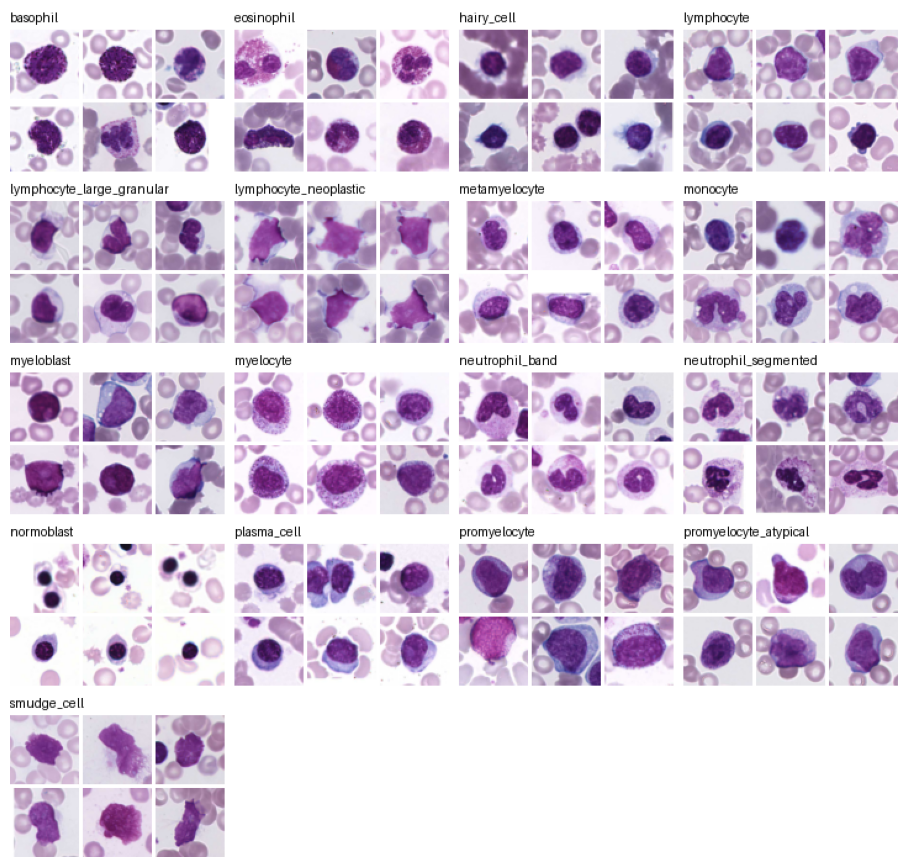

In [4]:
# Peek at the data, in a sexy fashion. Skip if broken.
_class_directories = sorted(
    p for p in DATA_ROOT.iterdir()
    if p.is_dir() and not p.name.startswith("__")
)
_thumbnail_size = 56; _images_per_class = 6
_panel_columns = 3; _panel_rows = 2
_image_padding = 3; _panel_padding = 8; _label_height = 16
_classes_per_row = 4
_class_count = len(_class_directories); _font = ImageFont.load_default()
_panel_width  = _panel_columns * _thumbnail_size + (_panel_columns - 1) * _image_padding
_panel_height = _label_height + _panel_rows * _thumbnail_size + (_panel_rows - 1) * _image_padding
_grid_columns = min(_classes_per_row, _class_count) if _class_count else _classes_per_row
_grid_rows    = math.ceil(_class_count / _grid_columns) if _class_count else 1
_canvas_width  = _grid_columns * _panel_width  + (_grid_columns - 1) * _panel_padding
_canvas_height = _grid_rows    * _panel_height + (_grid_rows    - 1) * _panel_padding
_canvas = Image.new("RGB", (_canvas_width, _canvas_height), "white")
_draw = ImageDraw.Draw(_canvas)
_image_positions = [
    (column_index, row_index)
    for row_index in range(_panel_rows)
    for column_index in range(_panel_columns)
]
for class_index, class_directory in enumerate(_class_directories):
    jpg_files = sorted(class_directory.rglob("*.jpg"))
    if not jpg_files: continue
    sample_images = random.sample(jpg_files, min(_images_per_class, len(jpg_files)))
    grid_row = class_index // _grid_columns; grid_column = class_index % _grid_columns
    x_offset = grid_column * (_panel_width + _panel_padding); y_offset = grid_row * (_panel_height + _panel_padding)
    _draw.text((x_offset, y_offset), class_directory.name, fill=(0, 0, 0), font=_font)
    for image_path, (column_index, row_index) in zip(sample_images, _image_positions):
        with Image.open(image_path) as image:
            image = image.convert("RGB").resize((_thumbnail_size, _thumbnail_size), Image.BILINEAR)
        pixel_x = x_offset + column_index * (_thumbnail_size + _image_padding)
        pixel_y = y_offset + _label_height + row_index * (_thumbnail_size + _image_padding)
        _canvas.paste(image, (pixel_x, pixel_y))
plt.figure(figsize=(12, max(4, _grid_rows * 2.2))); plt.imshow(_canvas); plt.axis("off"); plt.show()

In [5]:
def tensor_to_pil(tensor: torch.Tensor) -> Image.Image:
    tensor = tensor.detach()
    tensor = torch.clamp(tensor, 0.0, 1.0)
    tensor_u8 = torch.round(tensor * 255.0).clamp(0.0, 255.0).to(torch.uint8)
    return TVF.to_pil_image(tensor_u8)

def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    if img.mode != "RGB":
        img = img.convert("RGB")
    return TVF.pil_to_tensor(img).to(dtype=torch.float32).div_(255.0)  # [C,H,W] in 0..1

@dataclass(frozen=True)
class Augmentation:
    flip_horizontal: bool
    rotation_degrees: int
    translation_x: int
    translation_y: int
    brightness_factor: float = 1.0
    contrast_factor: float = 1.0
    saturation_factor: float = 1.0

def _apply_color_pil(image: Image.Image, augmentation: Augmentation) -> Image.Image:
    output_image = image if image.mode == "RGB" else image.convert("RGB")
    if augmentation.brightness_factor != 1.0:
        enhancer = ImageEnhance.Brightness(output_image)
        output_image = enhancer.enhance(float(augmentation.brightness_factor))
    if augmentation.contrast_factor != 1.0:
        enhancer = ImageEnhance.Contrast(output_image)
        output_image = enhancer.enhance(float(augmentation.contrast_factor))
    if augmentation.saturation_factor != 1.0:
        enhancer = ImageEnhance.Color(output_image)
        output_image = enhancer.enhance(float(augmentation.saturation_factor))
    return output_image

In [6]:
def _apply_geometry_pil(
    image: Image.Image,
    augmentation: Augmentation,
    background_rgb: RGB,
) -> Image.Image:
    # Flip
    output_image = (
        image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        if augmentation.flip_horizontal
        else image
    )

    # Rotate (only the standard right angles)
    rotation_degrees = augmentation.rotation_degrees % 360
    if rotation_degrees == 90:
        output_image = output_image.transpose(Image.Transpose.ROTATE_90)
    elif rotation_degrees == 180:
        output_image = output_image.transpose(Image.Transpose.ROTATE_180)
    elif rotation_degrees == 270:
        output_image = output_image.transpose(Image.Transpose.ROTATE_270)
    elif rotation_degrees != 0:
        raise ValueError("rotation_degrees must be one of {0, 90, 180, 270}")

    if output_image.mode != "RGB":
        output_image = output_image.convert("RGB")

    image_array = np.asarray(output_image); image_height, image_width, _channels = image_array.shape
    translation_x = int(augmentation.translation_x); translation_y = int(augmentation.translation_y)
    background_r, background_g, background_b = (int(background_rgb[0]), int(background_rgb[1]), int(background_rgb[2]))
    output_array = np.empty((image_height, image_width, 3), dtype=image_array.dtype)
    output_array[:, :] = np.array([background_r, background_g, background_b], dtype=image_array.dtype)
    source_x0 = max(0, -translation_x); source_y0 = max(0, -translation_y)
    source_x1 = min(image_width, image_width - translation_x); source_y1 = min(image_height, image_height - translation_y)
    destination_x0 = max(0, translation_x); destination_y0 = max(0, translation_y)
    destination_x1 = destination_x0 + (source_x1 - source_x0); destination_y1 = destination_y0 + (source_y1 - source_y0)

    if source_x1 > source_x0 and source_y1 > source_y0:
        output_array[destination_y0:destination_y1, destination_x0:destination_x1] = image_array[source_y0:source_y1, source_x0:source_x1]

    return Image.fromarray(output_array)

In [7]:
def apply_augmentation(
    image: Image.Image,
    augmentation: Augmentation,
    background_rgb: RGB = (255, 255, 255),
) -> Image.Image:
    translation_x = int(augmentation.translation_x); translation_y = int(augmentation.translation_y)
    rotation_degrees = augmentation.rotation_degrees % 360
    needs_geometry = (augmentation.flip_horizontal or rotation_degrees != 0
                      or translation_x != 0 or translation_y != 0)
    if needs_geometry:
        output_image = _apply_geometry_pil(image, augmentation, background_rgb)
    elif image.mode != "RGB":
        output_image = image.convert("RGB")
    else:
        output_image = image
    needs_color = (augmentation.brightness_factor != 1.0 or augmentation.contrast_factor != 1.0 or
                   augmentation.saturation_factor != 1.0)
    if needs_color:
        return _apply_color_pil(output_image, augmentation)
    else:
        return output_image
    
def make_random_augmentation(random_generator: random.Random) -> Augmentation:
    return Augmentation(
        flip_horizontal=random_generator.choice([False, True]),
        rotation_degrees=random_generator.choice(AUGMENTATION_ROTATION_VALUES),
        translation_x=random_generator.choice(AUGMENTATION_TRANSLATION_VALUES),
        translation_y=random_generator.choice(AUGMENTATION_TRANSLATION_VALUES),
        brightness_factor=random_generator.uniform(AUGMENTATION_BRIGHTNESS_MIN, AUGMENTATION_BRIGHTNESS_MAX),
        contrast_factor=random_generator.uniform(AUGMENTATION_CONTRAST_MIN, AUGMENTATION_CONTRAST_MAX),
        saturation_factor=random_generator.uniform(AUGMENTATION_SATURATION_MIN, AUGMENTATION_SATURATION_MAX),
    )
    
@dataclass(frozen=True)
class FileReference:
    path: Path
    def __init__(self, path: PathLike):
        object.__setattr__(self, "path", Path(path))

@dataclass(frozen=True)
class FileReferenceAndAugmentation:
    file_reference: FileReference
    augmentation: Optional[Augmentation]

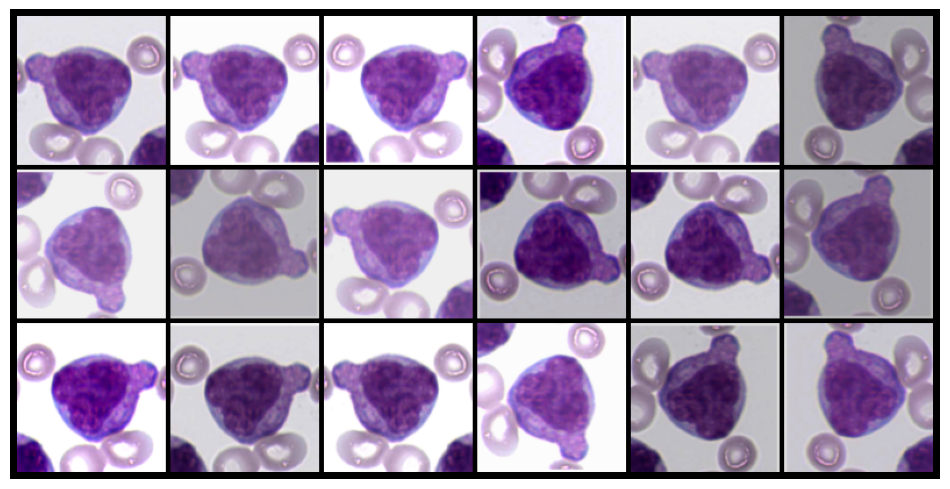

In [8]:
# Let's look at some augmentations. Optional cell. Skip if it's broken.
_grid_columns = 6; _grid_rows = 3; _thumbnail_size = 128
_outer_padding = 6; _image_padding = 4
_sample_file_path = jpg_file_list[9999]
with Image.open(_sample_file_path) as _image:
    _base_image = _image.convert("RGB")
_identity_augmentation = Augmentation(
    flip_horizontal=False, rotation_degrees=0,
    translation_x=0, translation_y=0,
    brightness_factor=1.0, contrast_factor=1.0, saturation_factor=1.0,
)
def _make_random_augmentation_exaggerated() -> Augmentation:
    return Augmentation(
        flip_horizontal=random.choice([False, True]),
        rotation_degrees=random.choice(AUGMENTATION_ROTATION_VALUES),
        translation_x=random.choice(AUGMENTATION_TRANSLATION_VALUES),
        translation_y=random.choice(AUGMENTATION_TRANSLATION_VALUES),
        brightness_factor=random.uniform(AUGMENTATION_BRIGHTNESS_MIN * 0.75, AUGMENTATION_BRIGHTNESS_MAX * 1.15),
        contrast_factor=random.uniform(AUGMENTATION_CONTRAST_MIN * 0.75, AUGMENTATION_CONTRAST_MAX * 1.15),
        saturation_factor=random.uniform(AUGMENTATION_SATURATION_MIN * 0.75, AUGMENTATION_SATURATION_MAX * 1.15)
    )
_canvas_width  = _grid_columns * _thumbnail_size + (_grid_columns - 1) * _image_padding + 2 * _outer_padding
_canvas_height = _grid_rows    * _thumbnail_size + (_grid_rows    - 1) * _image_padding + 2 * _outer_padding
_canvas = Image.new("RGB", (_canvas_width, _canvas_height), (0, 0, 0))
for _row_index in range(_grid_rows):
    for _column_index in range(_grid_columns):
        _augmentation = _identity_augmentation if (_row_index == 0 and _column_index == 0) else _make_random_augmentation_exaggerated()
        _output_image = apply_augmentation(_base_image, _augmentation).resize((_thumbnail_size, _thumbnail_size), Image.BILINEAR)
        _x = _outer_padding + _column_index * (_thumbnail_size + _image_padding)
        _y = _outer_padding + _row_index * (_thumbnail_size + _image_padding)
        _canvas.paste(_output_image, (_x, _y))

plt.figure(figsize=(12, 9)); plt.imshow(_canvas); plt.axis("off"); plt.show()

In [10]:
class_directories = sorted(
    class_directory
    for class_directory in DATA_ROOT.iterdir()
    if class_directory.is_dir()
    and not class_directory.name.startswith("__")
)

file_reference_table = defaultdict(list)
all_file_references: List[FileReference] = []

for class_directory in class_directories:
    class_name = class_directory.name
    for file_path in sorted(class_directory.rglob("*.jpg")):
        if file_path.is_file() and file_path.suffix.lower() == ".jpg":
            file_reference = FileReference(file_path)
            file_reference_table[class_name].append(file_reference)
            all_file_references.append(file_reference)

class_directories = sorted(
    class_directory
    for class_directory in DATA_ROOT.iterdir()
    if class_directory.is_dir()
    and not class_directory.name.startswith("__")
)

class_names: List[str] = [ class_directory.name for class_directory in class_directories ]
class_count = len(class_names)
class_index_table: Dict[str, int] = { class_name: class_index for class_index, class_name in enumerate(class_names) }
class_name_table: Dict[int, str] = { class_index: class_name for class_name, class_index in class_index_table.items() }

for class_name in class_names:
    class_index = class_index_table[class_name]
    class_name_refetch = class_name_table[class_index]
    length = len(file_reference_table[class_name])
    print(f"🔍 Found class: {class_name} ({class_index} => {class_name_refetch}) with {length} samples.")

"""
🔍 Found class: basophil (0 => basophil) with 616 samples.
🔍 Found class: eosinophil (1 => eosinophil) with 2000 samples.
🔍 Found class: hairy_cell (2 => hairy_cell) with 2000 samples.
🔍 Found class: lymphocyte (3 => lymphocyte) with 2000 samples.
🔍 Found class: lymphocyte_large_granular (4 => lymphocyte_large_granular) with 1849 samples.
🔍 Found class: lymphocyte_neoplastic (5 => lymphocyte_neoplastic) with 180 samples.
🔍 Found class: metamyelocyte (6 => metamyelocyte) with 483 samples.
🔍 Found class: monocyte (7 => monocyte) with 2000 samples.
🔍 Found class: myeloblast (8 => myeloblast) with 2000 samples.
🔍 Found class: myelocyte (9 => myelocyte) with 747 samples.
🔍 Found class: neutrophil_band (10 => neutrophil_band) with 687 samples.
🔍 Found class: neutrophil_segmented (11 => neutrophil_segmented) with 2000 samples.
🔍 Found class: normoblast (12 => normoblast) with 2000 samples.
🔍 Found class: plasma_cell (13 => plasma_cell) with 1658 samples.
🔍 Found class: promyelocyte (14 => promyelocyte) with 745 samples.
🔍 Found class: promyelocyte_atypical (15 => promyelocyte_atypical) with 2000 samples.
🔍 Found class: smudge_cell (16 => smudge_cell) with 988 samples.
"""


🔍 Found class: basophil (0 => basophil) with 616 samples.
🔍 Found class: eosinophil (1 => eosinophil) with 2000 samples.
🔍 Found class: hairy_cell (2 => hairy_cell) with 2000 samples.
🔍 Found class: lymphocyte (3 => lymphocyte) with 2000 samples.
🔍 Found class: lymphocyte_large_granular (4 => lymphocyte_large_granular) with 1849 samples.
🔍 Found class: lymphocyte_neoplastic (5 => lymphocyte_neoplastic) with 180 samples.
🔍 Found class: metamyelocyte (6 => metamyelocyte) with 483 samples.
🔍 Found class: monocyte (7 => monocyte) with 2000 samples.
🔍 Found class: myeloblast (8 => myeloblast) with 2000 samples.
🔍 Found class: myelocyte (9 => myelocyte) with 747 samples.
🔍 Found class: neutrophil_band (10 => neutrophil_band) with 687 samples.
🔍 Found class: neutrophil_segmented (11 => neutrophil_segmented) with 2000 samples.
🔍 Found class: normoblast (12 => normoblast) with 2000 samples.
🔍 Found class: plasma_cell (13 => plasma_cell) with 1658 samples.
🔍 Found class: promyelocyte (14 => prom

'\n🔍 Found class: basophil (0 => basophil) with 616 samples.\n🔍 Found class: eosinophil (1 => eosinophil) with 2000 samples.\n🔍 Found class: hairy_cell (2 => hairy_cell) with 2000 samples.\n🔍 Found class: lymphocyte (3 => lymphocyte) with 2000 samples.\n🔍 Found class: lymphocyte_large_granular (4 => lymphocyte_large_granular) with 1849 samples.\n🔍 Found class: lymphocyte_neoplastic (5 => lymphocyte_neoplastic) with 180 samples.\n🔍 Found class: metamyelocyte (6 => metamyelocyte) with 483 samples.\n🔍 Found class: monocyte (7 => monocyte) with 2000 samples.\n🔍 Found class: myeloblast (8 => myeloblast) with 2000 samples.\n🔍 Found class: myelocyte (9 => myelocyte) with 747 samples.\n🔍 Found class: neutrophil_band (10 => neutrophil_band) with 687 samples.\n🔍 Found class: neutrophil_segmented (11 => neutrophil_segmented) with 2000 samples.\n🔍 Found class: normoblast (12 => normoblast) with 2000 samples.\n🔍 Found class: plasma_cell (13 => plasma_cell) with 1658 samples.\n🔍 Found class: promyel

In [11]:
train_file_reference_table: Dict[str, List[FileReference]] = {}
validation_file_reference_table: Dict[str, List[FileReference]] = {}
test_file_reference_table: Dict[str, List[FileReference]] = {}

SPLIT_SEED = 777

def _stable_u32(text: str) -> int:
    import hashlib
    digest = hashlib.blake2b(text.encode("utf-8"),digest_size=4).digest()
    return int.from_bytes(digest, "little")

def split_list_deterministic(
    items: List[FileReference],
    seed: int,
) -> tuple[List[FileReference], List[FileReference], List[FileReference]]:
    items = sorted(
        items,
        key=lambda file_reference: file_reference.path.as_posix(),
    )
    items = list(items)
    random_generator = random.Random(seed)
    random_generator.shuffle(items)
    item_count = len(items)
    test_count = int(item_count * SPLIT_PERCENT_TEST)
    validation_count = int(item_count * SPLIT_PERCENT_VALIDATION)
    train_count = item_count - test_count - validation_count
    if item_count and train_count <= 0:
        train_count = 1
        leftover = item_count - train_count
        validation_count = min(validation_count, leftover)
        test_count = min(test_count, leftover - validation_count)

    train_items = items[:train_count]
    validation_items = items[train_count:train_count + validation_count]
    test_items = items[train_count + validation_count:train_count + validation_count + test_count]
    return train_items, validation_items, test_items

for class_name in class_names:
    class_file_references = file_reference_table.get(class_name, [])
    class_seed = _stable_u32(f"{SPLIT_SEED}|{class_name}")
    train_items, validation_items, test_items = split_list_deterministic(class_file_references, class_seed)
    train_file_reference_table[class_name] = train_items
    validation_file_reference_table[class_name] = validation_items
    test_file_reference_table[class_name] = test_items


In [12]:
holdout_file_reference_table: Dict[str, List[FileReference]] = {
    class_name: (
        validation_file_reference_table[class_name]
        + test_file_reference_table[class_name]
    )
    for class_name in class_names
}

for class_name in class_names:
    train_count = len(train_file_reference_table.get(class_name, []))
    validation_count = len(validation_file_reference_table.get(class_name, []))
    test_count = len(test_file_reference_table.get(class_name, []))

    print(
        f"{class_name:>20s} | "
        f"train={train_count:4d} | "
        f"val={validation_count:4d} | "
        f"test={test_count:4d}"
    )

    """
                basophil | train= 370 | val= 123 | test= 123
          eosinophil | train=1200 | val= 400 | test= 400
          hairy_cell | train=1200 | val= 400 | test= 400
          lymphocyte | train=1200 | val= 400 | test= 400
lymphocyte_large_granular | train=1111 | val= 369 | test= 369
lymphocyte_neoplastic | train= 108 | val=  36 | test=  36
       metamyelocyte | train= 291 | val=  96 | test=  96
            monocyte | train=1200 | val= 400 | test= 400
          myeloblast | train=1200 | val= 400 | test= 400
           myelocyte | train= 449 | val= 149 | test= 149
     neutrophil_band | train= 413 | val= 137 | test= 137
neutrophil_segmented | train=1200 | val= 400 | test= 400
          normoblast | train=1200 | val= 400 | test= 400
         plasma_cell | train= 996 | val= 331 | test= 331
        promyelocyte | train= 447 | val= 149 | test= 149
promyelocyte_atypical | train=1200 | val= 400 | test= 400
         smudge_cell | train= 594 | val= 197 | test= 197

Totals:
               TOTAL | train=14379 | val=4787 | test=4787
    """

            basophil | train= 370 | val= 123 | test= 123
          eosinophil | train=1200 | val= 400 | test= 400
          hairy_cell | train=1200 | val= 400 | test= 400
          lymphocyte | train=1200 | val= 400 | test= 400
lymphocyte_large_granular | train=1111 | val= 369 | test= 369
lymphocyte_neoplastic | train= 108 | val=  36 | test=  36
       metamyelocyte | train= 291 | val=  96 | test=  96
            monocyte | train=1200 | val= 400 | test= 400
          myeloblast | train=1200 | val= 400 | test= 400
           myelocyte | train= 449 | val= 149 | test= 149
     neutrophil_band | train= 413 | val= 137 | test= 137
neutrophil_segmented | train=1200 | val= 400 | test= 400
          normoblast | train=1200 | val= 400 | test= 400
         plasma_cell | train= 996 | val= 331 | test= 331
        promyelocyte | train= 447 | val= 149 | test= 149
promyelocyte_atypical | train=1200 | val= 400 | test= 400
         smudge_cell | train= 594 | val= 197 | test= 197


In [13]:
def build_balanced_train_items(class_name: str) -> List[FileReferenceAndAugmentation]:
    base_file_references = train_file_reference_table.get(class_name, [])

    items: List[FileReferenceAndAugmentation] = [
        FileReferenceAndAugmentation(file_reference=file_reference, augmentation=None)
        for file_reference in base_file_references
    ]

    if not base_file_references:
        return items

    random_generator = random.Random(_stable_u32(f"{SPLIT_SEED}|balance|{class_name}"))
    if len(items) > BALANCE_TARGET_COUNT_PER_CLASS:
        random_generator.shuffle(items)
        items = items[:BALANCE_TARGET_COUNT_PER_CLASS]
    while len(items) < BALANCE_TARGET_COUNT_PER_CLASS:
        source_file_reference = random_generator.choice(base_file_references)
        augmentation = make_random_augmentation(random_generator)
        items.append(FileReferenceAndAugmentation(file_reference=source_file_reference, augmentation=augmentation))
    return items

train_augmented_table: Dict[str, List[FileReferenceAndAugmentation]] = {}
validation_augmented_table: Dict[str, List[FileReferenceAndAugmentation]] = {}
test_augmented_table: Dict[str, List[FileReferenceAndAugmentation]] = {}

train_augmented_all: List[FileReferenceAndAugmentation] = []
validation_augmented_all: List[FileReferenceAndAugmentation] = []
test_augmented_all: List[FileReferenceAndAugmentation] = []

In [14]:

for class_name in class_names:
    # train
    train_items = build_balanced_train_items(class_name)
    train_augmented_table[class_name] = train_items
    train_augmented_all.extend(train_items)

    augmentation_count = sum(
        1 for item in train_items
        if item.augmentation is not None
    )
    total_count = len(train_items)
    real_count = total_count - augmentation_count

    # validation
    validation_file_references = validation_file_reference_table.get(class_name, [])
    validation_items = [
        FileReferenceAndAugmentation(
            file_reference=file_reference,
            augmentation=None,
        )
        for file_reference in validation_file_references
    ]
    validation_augmented_table[class_name] = validation_items
    validation_augmented_all.extend(validation_items)

    # test
    test_file_references = test_file_reference_table.get(class_name, [])
    test_items = [
        FileReferenceAndAugmentation(
            file_reference=file_reference,
            augmentation=None,
        )
        for file_reference in test_file_references
    ]
    test_augmented_table[class_name] = test_items
    test_augmented_all.extend(test_items)

    if total_count == 0:
        print(
            f"⚠️ {class_name}: "
            f"train=0 (cannot balance) | "
            f"validation={len(validation_items)} | "
            f"test={len(test_items)}"
        )
    else:
        print(
            f"✅ {class_name}: "
            f"train={total_count} (real={real_count}, augmented={augmentation_count}) | "
            f"validation={len(validation_items)} | "
            f"test={len(test_items)}"
        )

"""
✅ basophil: train=2000 (real=370, augmented=1630) | validation=123 | test=123
✅ eosinophil: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ hairy_cell: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ lymphocyte: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ lymphocyte_large_granular: train=2000 (real=1111, augmented=889) | validation=369 | test=369
✅ lymphocyte_neoplastic: train=2000 (real=108, augmented=1892) | validation=36 | test=36
✅ metamyelocyte: train=2000 (real=291, augmented=1709) | validation=96 | test=96
✅ monocyte: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ myeloblast: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ myelocyte: train=2000 (real=449, augmented=1551) | validation=149 | test=149
✅ neutrophil_band: train=2000 (real=413, augmented=1587) | validation=137 | test=137
✅ neutrophil_segmented: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ normoblast: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ plasma_cell: train=2000 (real=996, augmented=1004) | validation=331 | test=331
✅ promyelocyte: train=2000 (real=447, augmented=1553) | validation=149 | test=149
✅ promyelocyte_atypical: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ smudge_cell: train=2000 (real=594, augmented=1406) | validation=197 | test=197
"""

✅ basophil: train=2000 (real=370, augmented=1630) | validation=123 | test=123
✅ eosinophil: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ hairy_cell: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ lymphocyte: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ lymphocyte_large_granular: train=2000 (real=1111, augmented=889) | validation=369 | test=369
✅ lymphocyte_neoplastic: train=2000 (real=108, augmented=1892) | validation=36 | test=36
✅ metamyelocyte: train=2000 (real=291, augmented=1709) | validation=96 | test=96
✅ monocyte: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ myeloblast: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ myelocyte: train=2000 (real=449, augmented=1551) | validation=149 | test=149
✅ neutrophil_band: train=2000 (real=413, augmented=1587) | validation=137 | test=137
✅ neutrophil_segmented: train=2000 (real=1200, augmented=800) | validation=400 | test=400
✅ nor

'\n✅ basophil: train=2000 (real=370, augmented=1630) | validation=123 | test=123\n✅ eosinophil: train=2000 (real=1200, augmented=800) | validation=400 | test=400\n✅ hairy_cell: train=2000 (real=1200, augmented=800) | validation=400 | test=400\n✅ lymphocyte: train=2000 (real=1200, augmented=800) | validation=400 | test=400\n✅ lymphocyte_large_granular: train=2000 (real=1111, augmented=889) | validation=369 | test=369\n✅ lymphocyte_neoplastic: train=2000 (real=108, augmented=1892) | validation=36 | test=36\n✅ metamyelocyte: train=2000 (real=291, augmented=1709) | validation=96 | test=96\n✅ monocyte: train=2000 (real=1200, augmented=800) | validation=400 | test=400\n✅ myeloblast: train=2000 (real=1200, augmented=800) | validation=400 | test=400\n✅ myelocyte: train=2000 (real=449, augmented=1551) | validation=149 | test=149\n✅ neutrophil_band: train=2000 (real=413, augmented=1587) | validation=137 | test=137\n✅ neutrophil_segmented: train=2000 (real=1200, augmented=800) | validation=400 | 

In [15]:
def crop_inset_and_resize(
    image: Image.Image,
    inset: int,
    network_size: int,
) -> Image.Image:
    if image.mode != "RGB":
        image = image.convert("RGB")
    width, height = image.size
    inset = int(max(0, inset))
    crop_width = width - 2 * inset
    crop_height = height - 2 * inset
    if crop_width <= 1 or crop_height <= 1:
        square_size = max(1, min(width, height))
        left = (width - square_size) // 2
        top = (height - square_size) // 2
        image = image.crop((left, top, left + square_size, top + square_size))
    else:
        image = image.crop((inset, inset, width - inset, height - inset))
    return image.resize((network_size, network_size), resample=Image.Resampling.BILINEAR)

def apply_clahe(
    image: Image.Image
) -> Image.Image:
    if image.mode != "RGB":
        image = image.convert("RGB")
    rgb_u8 = np.asarray(image)
    lab_u8 = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2LAB)
    l_u8, a_u8, b_u8 = cv2.split(lab_u8)
    clahe = cv2.createCLAHE(
        clipLimit=float(CLAHE_CLIP_LIMIT),
        tileGridSize=tuple(CLAHE_TILE_GRID_SIZE),
    )
    l2_u8 = clahe.apply(l_u8)
    lab2_u8 = cv2.merge([l2_u8, a_u8, b_u8])
    rgb2_u8 = cv2.cvtColor(lab2_u8, cv2.COLOR_LAB2RGB)
    return Image.fromarray(rgb2_u8)

def apply_denoise(
    image: Image.Image,
) -> Image.Image:
    if image.mode != "RGB":
        image = image.convert("RGB")
    rgb_u8 = np.asarray(image)
    bgr_u8 = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2BGR)
    denoised_bgr_u8 = cv2.fastNlMeansDenoisingColored(
        bgr_u8, None,
        h=int(DENOISE_LUMINANCE_STRENGTH), hColor=int(DENOISE_COLOR_STRENGTH),
        templateWindowSize=int(DENOISE_TEMPLATE_WINDOW_SIZE),
        searchWindowSize=int(DENOISE_SEARCH_WINDOW_SIZE),
    )
    denoised_rgb_u8 = cv2.cvtColor(denoised_bgr_u8, cv2.COLOR_BGR2RGB)
    return Image.fromarray(denoised_rgb_u8)

In [16]:
def apply_lab(
    image: Image.Image,
) -> Image.Image:
    if image.mode != "RGB":
        image = image.convert("RGB")
    rgb_u8 = np.asarray(image)
    lab_f32 = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2LAB).astype(np.float32)
    l_f32, a_f32, b_f32 = cv2.split(lab_f32)
    epsilon = 1e-6
    luminance_mean = float(l_f32.mean())
    luminance_std = float(l_f32.std()) + epsilon
    l_f32 = (l_f32 - luminance_mean) / luminance_std * float(LAB_NORMALIZATION_TARGET_STD) + float(LAB_NORMALIZATION_TARGET_MEAN)
    l_u8 = np.clip(l_f32, 0.0, 255.0).astype(np.uint8)
    a_u8 = np.clip(a_f32, 0.0, 255.0).astype(np.uint8)
    b_u8 = np.clip(b_f32, 0.0, 255.0).astype(np.uint8)
    rgb2_u8 = cv2.cvtColor(cv2.merge([l_u8, a_u8, b_u8]), cv2.COLOR_LAB2RGB)
    return Image.fromarray(rgb2_u8)

def apply_reinhard(image: Image.Image) -> Image.Image:
    if image.mode != "RGB":
        image = image.convert("RGB")
    rgb_u8 = np.asarray(image)
    lab_f32 = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2LAB).astype(np.float32)
    l_f32, a_f32, b_f32 = cv2.split(lab_f32)
    target_l_mean, target_l_std = 165.0, 35.0
    target_a_mean, target_a_std = 135.0, 12.0
    target_b_mean, target_b_std = 140.0, 12.0
    epsilon = 1e-6
    source_l_mean, source_l_std = float(l_f32.mean()), float(l_f32.std()) + epsilon
    source_a_mean, source_a_std = float(a_f32.mean()), float(a_f32.std()) + epsilon
    source_b_mean, source_b_std = float(b_f32.mean()), float(b_f32.std()) + epsilon
    l_f32 = (l_f32 - source_l_mean) / source_l_std * target_l_std + target_l_mean
    a_f32 = (a_f32 - source_a_mean) / source_a_std * target_a_std + target_a_mean
    b_f32 = (b_f32 - source_b_mean) / source_b_std * target_b_std + target_b_mean
    lab_u8 = cv2.merge([
        np.clip(l_f32, 0.0, 255.0), np.clip(a_f32, 0.0, 255.0), np.clip(b_f32, 0.0, 255.0),
    ]).astype(np.uint8)
    rgb2_u8 = cv2.cvtColor(lab_u8, cv2.COLOR_LAB2RGB)
    return Image.fromarray(rgb2_u8)

In [19]:
class PreprocessingMode(Enum):
    LAB = "lab"
    REINHARD = "reinhard"

@dataclass(frozen=True)
class PreprocessConfig:
    mode: Optional[PreprocessingMode] = None
    clahe: bool = False
    denoise: bool = False

def preprocess_image(
    image: Image.Image,
    mode: Optional[PreprocessingMode],
    clahe: bool,
    denoise: bool,
) -> Image.Image:
    if mode is not None:
        if mode == PreprocessingMode.LAB:
            image = apply_lab(image)
        elif mode == PreprocessingMode.REINHARD:
            image = apply_reinhard(image)
        else:
            raise ValueError(f"Unknown PreprocessingMode: {mode!r}")
    if clahe:
        image = apply_clahe(image)
    if denoise:
        image = apply_denoise(image)
    return image

def image_from_file_reference(file_reference: FileReference) -> Image.Image:
    """Load an image from disk with no augmentation."""
    with Image.open(file_reference.path) as im:
        im = im.convert("RGB") if im.mode != "RGB" else im.copy()
    return im

def image_from_file_reference_augmented(fra: FileReferenceAndAugmentation) -> Image.Image:
    """Load an image and apply augmentation if present."""
    img = image_from_file_reference(fra.file_reference)
    return apply_augmentation(img, fra.augmentation) if fra.augmentation is not None else img

Samples:
  leuko_fatty_256/lymphocyte_large_granular/lymphocyte_large_granular_1304.jpg
  leuko_fatty_256/lymphocyte/lymphocyte_1672.jpg
  leuko_fatty_256/lymphocyte/lymphocyte_1458.jpg
  leuko_fatty_256/eosinophil/eosinophil_0764.jpg


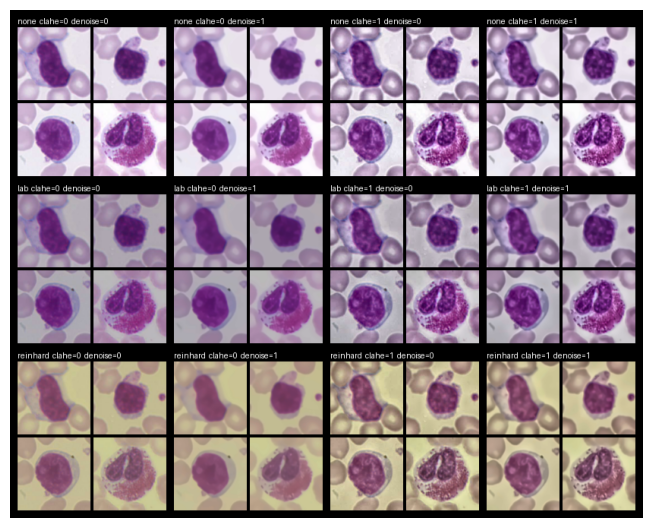

In [20]:
# Peek at preprocessing combinations (no DataLoader). Optional cell. Skip if it's broken.
_seed = 777; _random_generator = random.Random(_seed)

_samples_per_cell = 4; _samples_grid_columns = 2; _samples_grid_rows = 2
_thumbnail_size = 96; _thumbnail_padding = 4; _panel_padding = 10; _label_height = 14; _outer_padding = 10
_font = ImageFont.load_default()

if len(jpg_file_list) == 0: raise RuntimeError(f"No .jpg files found under {DATA_ROOT}")

_sample_file_paths = _random_generator.sample(jpg_file_list, k=min(_samples_per_cell, len(jpg_file_list)))
print("Samples:"); [print(" ", _file_path) for _file_path in _sample_file_paths]

_mode_rows: list[tuple[str, Optional[PreprocessingMode]]] = [("none", None), ("lab", PreprocessingMode.LAB), ("reinhard", PreprocessingMode.REINHARD)]
_flag_columns: list[tuple[int, int]] = [(0, 0), (0, 1), (1, 0), (1, 1)]

_cell_image_width  = _samples_grid_columns * _thumbnail_size + (_samples_grid_columns - 1) * _thumbnail_padding
_cell_image_height = _samples_grid_rows    * _thumbnail_size + (_samples_grid_rows    - 1) * _thumbnail_padding
_cell_width = _cell_image_width; _cell_height = _label_height + _cell_image_height

_canvas_width  = len(_flag_columns) * _cell_width  + (len(_flag_columns) - 1) * _panel_padding + 2 * _outer_padding
_canvas_height = len(_mode_rows)    * _cell_height + (len(_mode_rows)    - 1) * _panel_padding + 2 * _outer_padding

_canvas = Image.new("RGB", (_canvas_width, _canvas_height), (0, 0, 0)); _draw = ImageDraw.Draw(_canvas)

for _row_index, (_mode_label, _mode_value) in enumerate(_mode_rows):
    for _column_index, (_clahe_flag, _denoise_flag) in enumerate(_flag_columns):
        _x0 = _outer_padding + _column_index * (_cell_width + _panel_padding)
        _y0 = _outer_padding + _row_index    * (_cell_height + _panel_padding)
        _draw.text((_x0, _y0), f"{_mode_label}  clahe={_clahe_flag}  denoise={_denoise_flag}", fill=(255, 255, 255), font=_font)

        for _sample_index, _file_path in enumerate(_sample_file_paths):
            _sample_row = _sample_index // _samples_grid_columns; _sample_column = _sample_index % _samples_grid_columns
            with Image.open(_file_path) as _image: _image_rgb = _image.convert("RGB")
            _image_rgb = crop_inset_and_resize(image=_image_rgb, inset=int(NETWORK_POST_AUGMENTATION_INSET), network_size=int(NETWORK_SIZE_CAMILA_A))
            _processed = preprocess_image(image=_image_rgb, mode=_mode_value, clahe=bool(_clahe_flag), denoise=bool(_denoise_flag))
            _thumbnail = _processed.resize((_thumbnail_size, _thumbnail_size), resample=Image.Resampling.BILINEAR)

            _pixel_x = _x0 + _sample_column * (_thumbnail_size + _thumbnail_padding)
            _pixel_y = _y0 + _label_height + _sample_row * (_thumbnail_size + _thumbnail_padding)
            _canvas.paste(_thumbnail, (_pixel_x, _pixel_y))

plt.figure(figsize=(14, max(4, len(_mode_rows) * 2.2))); plt.imshow(_canvas); plt.axis("off"); plt.show()


In [24]:
class DanielDataSet(Dataset):
    def __init__(
        self,
        items: List[FileReferenceAndAugmentation],
        preprocess_config_1: Optional[PreprocessConfig] = None,
        preprocess_config_2: Optional[PreprocessConfig] = None,
        preprocess_config_3: Optional[PreprocessConfig] = None,
    ):
        self.items = items
        self.preprocess_config_1 = preprocess_config_1
        self.preprocess_config_2 = preprocess_config_2
        self.preprocess_config_3 = preprocess_config_3

    def __len__(self) -> int:
        return len(self.items)

    def _class_name_from_path(self, file_path: Path) -> str:
        return file_path.relative_to(DATA_ROOT).parts[0]

    def _load_and_prepare_tensor(
        self,
        file_reference_and_augmentation: FileReferenceAndAugmentation,
        preprocess_config: Optional[PreprocessConfig],
        network_size: int,
    ) -> torch.Tensor:
        image = image_from_file_reference_augmented(
            file_reference_and_augmentation
        )

        image = crop_inset_and_resize(
            image=image,
            inset=int(NETWORK_POST_AUGMENTATION_INSET),
            network_size=int(network_size),
        )

        if preprocess_config is not None:
            image = preprocess_image(
                image=image,
                mode=preprocess_config.mode,
                clahe=bool(preprocess_config.clahe),
                denoise=bool(preprocess_config.denoise),
            )

        tensor = (
            TVF.pil_to_tensor(image)
            .to(dtype=torch.float32)
            .div_(255.0)
            .contiguous()
        )
        return tensor

    def __getitem__(
        self,
        index: int,
    ) -> tuple[tuple[torch.Tensor, torch.Tensor, torch.Tensor], int]:
        file_reference_and_augmentation = self.items[index]

        main_tensor = self._load_and_prepare_tensor(
            file_reference_and_augmentation=file_reference_and_augmentation,
            preprocess_config=self.preprocess_config_1,
            network_size=int(NETWORK_SIZE_DANIEL_A),
        )
        secondary_tensor_1 = self._load_and_prepare_tensor(
            file_reference_and_augmentation=file_reference_and_augmentation,
            preprocess_config=self.preprocess_config_2,
            network_size=int(NETWORK_SIZE_DANIEL_B),
        )
        secondary_tensor_2 = self._load_and_prepare_tensor(
            file_reference_and_augmentation=file_reference_and_augmentation,
            preprocess_config=self.preprocess_config_3,
            network_size=int(NETWORK_SIZE_DANIEL_B),
        )

        file_path = file_reference_and_augmentation.file_reference.path
        class_name = self._class_name_from_path(file_path)
        class_index = class_index_table[class_name]

        return (main_tensor, secondary_tensor_1, secondary_tensor_2), class_index


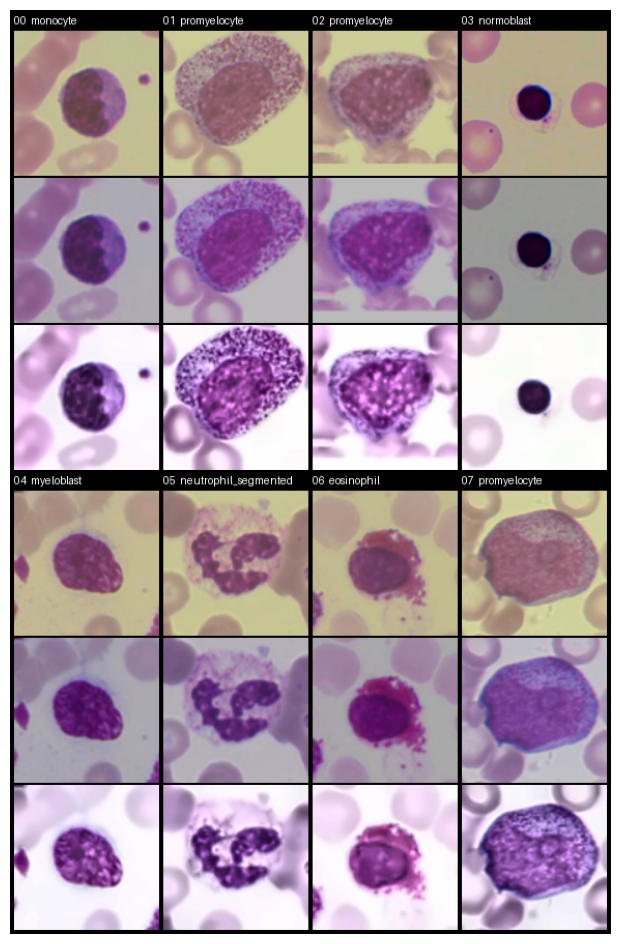

In [25]:
# Inspect DanielDataSet / DanielDataLoader output. Optional cell. Skip if it's broken.
_column_count=4; _sample_count=8; _thumb=140; _pad=2; _panel_pad=4; _outer_pad=4; _label_h=16; _font=ImageFont.load_default()

if not train_augmented_all: raise RuntimeError("train_augmented_all is empty")

_rng=random.Random(777)
_demo_items=_rng.sample(train_augmented_all, k=min(_sample_count,len(train_augmented_all)))

_demo_daniel_data_set=DanielDataSet(
    items=_demo_items,
    preprocess_config_1=PreprocessConfig(mode=PreprocessingMode.REINHARD),
    preprocess_config_2=PreprocessConfig(mode=PreprocessingMode.LAB),
    preprocess_config_3=PreprocessConfig(mode=None, clahe=True, denoise=True),
)
_demo_daniel_data_loader=DataLoader(_demo_daniel_data_set,batch_size=1,shuffle=False,num_workers=0)

_rows=math.ceil(_sample_count/_column_count)
_cell_w=_thumb; _cell_h=_label_h+3*_thumb+2*_pad
_canvas_w=_column_count*_cell_w+(_column_count-1)*_panel_pad+2*_outer_pad
_canvas_h=_rows*_cell_h+(_rows-1)*_panel_pad+2*_outer_pad
_canvas=Image.new("RGB",(_canvas_w,_canvas_h),(0,0,0)); _draw=ImageDraw.Draw(_canvas)

for i,((a,b1,b2),cls_idx) in enumerate(_demo_daniel_data_loader):
    r,c=divmod(i,_column_count)
    x=_outer_pad+c*(_cell_w+_panel_pad); y=_outer_pad+r*(_cell_h+_panel_pad)
    name=class_name_table[int(cls_idx)]
    _draw.text((x,y),f"{i:02d}  {name}",fill=(255,255,255),font=_font)
    for j,t in enumerate((a[0],b1[0],b2[0])):
        img=tensor_to_pil(t).resize((_thumb,_thumb),Image.Resampling.BILINEAR)
        _canvas.paste(img,(x,y+_label_h+j*(_thumb+_pad)))

plt.figure(figsize=(18,max(6,_rows*6))); plt.imshow(_canvas); plt.axis("off"); plt.show()

In [32]:
# ---- DanielModel ----
class DanielModel(nn.Module):
    """
    3-footed model:
      - main input: 224x224 -> c4 x 14 x 14  (4 pools)
      - two secondary inputs: 112x112 -> c3 x 14 x 14 (3 pools)
      - concat channels -> (c4 + c3 + c3) x 14 x 14
    """
    def __init__(self, num_classes: int, dropout: float = 0.2, stem: int = 32):
        super().__init__()

        def conv_bn_act(in_channels: int, out_channels: int, kernel_size: int = 3, padding: int = 1) -> nn.Module:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
            )

        c1 = stem
        c2 = stem * 2
        c3 = stem * 4
        c4 = stem * 8

        self.main_features = nn.Sequential(
            conv_bn_act(3,  c1), nn.MaxPool2d(2),  # 224 -> 112
            conv_bn_act(c1, c2), nn.MaxPool2d(2),  # 112 -> 56
            conv_bn_act(c2, c3), nn.MaxPool2d(2),  # 56 -> 28
            conv_bn_act(c3, c4),
            conv_bn_act(c4, c4), nn.MaxPool2d(2),  # 28 -> 14
        )

        self.secondary_features = nn.Sequential(
            conv_bn_act(3,  c1), nn.MaxPool2d(2),  # 112 -> 56
            conv_bn_act(c1, c2), nn.MaxPool2d(2),  # 56 -> 28
            conv_bn_act(c2, c3), nn.MaxPool2d(2),  # 28 -> 14
        )

        flat_dim = (c4 + c3 + c3) * 14 * 14
        self.head = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(flat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=float(dropout)),
            nn.Linear(512, int(num_classes)),
        )

    def forward(
        self,
        main_tensor: torch.Tensor | tuple[torch.Tensor, torch.Tensor, torch.Tensor] | list[torch.Tensor],
        secondary_tensor_1: Optional[torch.Tensor] = None,
        secondary_tensor_2: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        if secondary_tensor_1 is None and secondary_tensor_2 is None:
            if not (isinstance(main_tensor, (tuple, list)) and len(main_tensor) == 3):
                raise ValueError("Expected (main, secondary_1, secondary_2) if passing a single argument.")
            main_tensor, secondary_tensor_1, secondary_tensor_2 = main_tensor  # type: ignore[misc]

        if secondary_tensor_1 is None or secondary_tensor_2 is None:
            raise ValueError("secondary tensors must not be None.")

        main_features = self.main_features(main_tensor)
        secondary_features_1 = self.secondary_features(secondary_tensor_1)
        secondary_features_2 = self.secondary_features(secondary_tensor_2)

        merged_features = torch.cat([main_features, secondary_features_1, secondary_features_2], dim=1)
        return self.head(merged_features)

In [33]:
class_index_lut = class_index_table  # alias for compatibility
NUM_CLASSES = len(class_index_lut)

def get_device() -> torch.device:
    if torch.cuda.is_available(): return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()
print("Device:", DEVICE)
print("Num classes:", NUM_CLASSES)

PIN_MEMORY = False
NUM_WORKERS = 0

# ---- stats + io helpers (reuse your existing ones, but ensuring they exist) ----
@dataclass(frozen=True)
class TrainStats:
    loss: float
    acc: float

def _append_jsonl(path: Path, row: Dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

def _load_jsonl(path: Path) -> list[Dict]:
    if not path.exists(): return []
    out: list[Dict] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line: out.append(json.loads(line))
    return out

def ckpt_path(models_dir: Path, epoch: int) -> Path:
    return models_dir / f"train_model_{epoch:04d}.pt"

Device: mps
Num classes: 17


In [34]:
def save_checkpoint(path: Path, *, model: nn.Module, optimizer: torch.optim.Optimizer, classes: list[str], epoch: int, best_acc: float) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(
        {
            "epoch": int(epoch),
            "classes": classes,
            "arch": model.__class__.__name__,
            "best_acc": float(best_acc),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path,
    )

def load_checkpoint_into_existing_strict(path: Path, *, model: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device) -> tuple[int, float]:
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    if "optimizer_state_dict" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    return int(ckpt.get("epoch", 0)), float(ckpt.get("best_acc", 0.0))

def _latest_checkpoint_path(models_dir: Path) -> Optional[Path]:
    if not models_dir.exists(): return None
    candidates = sorted(models_dir.glob("train_model_*.pt"))
    return candidates[-1] if candidates else None

In [35]:
# ---- core epoch runner (FIX: xb is a tuple of tensors) ----
def fire_epoch(
    *,
    device: torch.device,
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optional[torch.optim.Optimizer],
    is_train: bool,
) -> TrainStats:
    model.train() if is_train else model.eval()
    if is_train and optimizer is None:
        raise ValueError("optimizer must not be None when is_train=True")

    total_loss = 0.0
    correct = 0
    total = 0
    ctx = torch.enable_grad() if is_train else torch.inference_mode()

    with ctx:
        for xb, yb in loader:
            # xb is (main, secondary1, secondary2)
            main_tensor, secondary_tensor_1, secondary_tensor_2 = xb
            main_tensor = main_tensor.to(device)
            secondary_tensor_1 = secondary_tensor_1.to(device)
            secondary_tensor_2 = secondary_tensor_2.to(device)
            yb = yb.to(device)

            if is_train:
                optimizer.zero_grad(set_to_none=True)

            logits = model((main_tensor, secondary_tensor_1, secondary_tensor_2))
            loss = criterion(logits, yb)

            if is_train:
                loss.backward()
                optimizer.step()

            batch_size = int(yb.numel())
            total += batch_size
            total_loss += float(loss.item()) * batch_size
            correct += int((logits.argmax(dim=1) == yb).sum().item())

    return TrainStats(loss=total_loss / max(1, total), acc=correct / max(1, total))

def train_one_epoch(*, device: torch.device, model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.Module) -> TrainStats:
    return fire_epoch(device=device, model=model, loader=loader, criterion=criterion, optimizer=optimizer, is_train=True)

def eval_one_epoch(*, device: torch.device, model: nn.Module, loader: DataLoader, criterion: nn.Module) -> TrainStats:
    return fire_epoch(device=device, model=model, loader=loader, criterion=criterion, optimizer=None, is_train=False)


In [36]:
def train_loop_iteration(
    *,
    epoch: int,
    device: torch.device,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    loader_train: DataLoader,
    loader_val: Optional[DataLoader],
) -> tuple[Dict, Dict]:
    t0 = time.time()
    tr = train_one_epoch(device=device, model=model, loader=loader_train, optimizer=optimizer, criterion=criterion)
    va = eval_one_epoch(device=device, model=model, loader=loader_val, criterion=criterion) if loader_val is not None else None
    secs = time.time() - t0
    lr = float(optimizer.param_groups[0].get("lr", 0.0))

    train_stats_row = {"epoch": int(epoch), "loss": float(tr.loss), "acc": float(tr.acc)}
    epoch_stats_row = {
        "epoch": int(epoch),
        "train_loss": float(tr.loss),
        "train_acc": float(tr.acc),
        "val_loss": (float(va.loss) if va else None),
        "val_acc":  (float(va.acc)  if va else None),
        "lr": float(lr),
        "seconds": float(secs),
    }
    return train_stats_row, epoch_stats_row

In [ ]:
# ============================================================
# Build Daniel datasets/loaders
# ============================================================
if len(train_augmented_all) == 0:
    raise RuntimeError("train_augmented_all is empty; build train_augmented_all before training.")
if len(validation_augmented_all) == 0:
    raise RuntimeError("validation_augmented_all is empty; build validation_augmented_all before training.")

preprocess_config_1 = PreprocessConfig(mode=PreprocessingMode.REINHARD, clahe=False, denoise=False)
preprocess_config_2 = PreprocessConfig(mode=PreprocessingMode.LAB,      clahe=True,  denoise=False)
preprocess_config_3 = PreprocessConfig(mode=PreprocessingMode.LAB,      clahe=False, denoise=True)

train_data_set = DanielDataSet(items=train_augmented_all, preprocess_config_1=preprocess_config_1, preprocess_config_2=preprocess_config_2, preprocess_config_3=preprocess_config_3)
val_data_set   = DanielDataSet(items=validation_augmented_all, preprocess_config_1=preprocess_config_1, preprocess_config_2=preprocess_config_2, preprocess_config_3=preprocess_config_3)

batch_size = int(MAGIC_BATCH_SIZE)
learning_rate = float(MAGIC_LEARNING_RATE)
weight_decay = float(MAGIC_WEIGHT_DECAY)

train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_data_set,   batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# ============================================================
# Model/optimizer + resume
# ============================================================
models_dir = Path("models/run_daniel_reinhard_lab_clahe_lab_denoise_224_112")
models_dir.mkdir(parents=True, exist_ok=True)

train_stats_path = models_dir / "train_stats.jsonl"
epoch_stats_path = models_dir / "epoch_stats.jsonl"
best_path = models_dir / "model_best.pt"

model = DanielModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
start_epoch = 1

latest_path = _latest_checkpoint_path(models_dir)
if latest_path is not None:
    last_epoch, best_acc = load_checkpoint_into_existing_strict(latest_path, model=model, optimizer=optimizer, device=DEVICE)
    start_epoch = int(last_epoch) + 1
    print(f"🟡 Resuming from {latest_path.name}: next_epoch={start_epoch} best_acc={best_acc:.4f}")
else:
    print("🟢 No checkpoint found, starting fresh.")

TRAIN_EPOCH_END = 20

print(f"Starting Pass, batch_size={batch_size}, weight_decay={weight_decay}, learning_rate={learning_rate}")

for epoch in range(start_epoch, TRAIN_EPOCH_END + 1):
    train_row, epoch_row = train_loop_iteration(
        epoch=epoch,
        device=DEVICE,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        loader_train=train_loader,
        loader_val=val_loader,
    )

    _append_jsonl(train_stats_path, train_row)
    _append_jsonl(epoch_stats_path, epoch_row)

    val_acc = epoch_row["val_acc"]
    score_acc = float(val_acc) if val_acc is not None else float(train_row["acc"])
    if score_acc >= best_acc:
        best_acc = float(score_acc)
        save_checkpoint(best_path, model=model, optimizer=optimizer, classes=class_names, epoch=epoch, best_acc=best_acc)
        print(f"[Best] epoch={epoch:02d} acc={best_acc:.4f}")

    save_checkpoint(ckpt_path(models_dir, epoch), model=model, optimizer=optimizer, classes=class_names, epoch=epoch, best_acc=best_acc)

    msg = (
        f"@ lr = {learning_rate:.8f}, batch = {batch_size}, w_decay = {weight_decay:.8f}, "
        f"epoch {epoch:02d} | tr {train_row['loss']:.4f}/{train_row['acc']:.4f}"
    )
    if epoch_row["val_loss"] is not None:
        msg += f" | va {epoch_row['val_loss']:.4f}/{epoch_row['val_acc']:.4f}"
    msg += f" | lr {epoch_row['lr']:.8f} | {epoch_row['seconds']:.1f}s"
    print(msg)

🟢 No checkpoint found, starting fresh.
Starting Pass, batch_size=12, weight_decay=0.0025, learning_rate=2.8e-05
